In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from scipy.stats import multivariate_normal
from scipy.interpolate import griddata
from shapely.geometry import Point

def calculate_probabilities(data, covariance_matrix):
    coordinates = np.vstack((data['lat'], data['lon'])).T
    probabilities = np.zeros(len(data))

    for coordinate in coordinates:
        rv = multivariate_normal(coordinate, covariance_matrix)
        probabilities += rv.pdf(coordinates)

    return probabilities

def interpolate_probabilities(gdf, points='auto'):
    if points == 'auto':
        x = np.linspace(gdf.total_bounds[0], gdf.total_bounds[2], 500)
        y = np.linspace(gdf.total_bounds[1], gdf.total_bounds[3], 500)
    else:
        x = np.linspace(gdf.total_bounds[0], gdf.total_bounds[2], points)
        y = np.linspace(gdf.total_bounds[1], gdf.total_bounds[3], points)
    xx, yy = np.meshgrid(x, y)
    interpolated_probabilities = griddata(
        gdf[['x', 'y']], gdf['normalized_probability'], (xx, yy), method='cubic')
    return xx, yy, interpolated_probabilities

def main(file_path, covariance_value):
    data = pd.read_csv(file_path)

    # Define the covariance matrix
    covariance_matrix = np.array([[covariance_value, 0], [0, covariance_value]])

    # Compute Gaussian probabilities
    data['probability'] = calculate_probabilities(data, covariance_matrix)

    # Normalize the probabilities
    data['normalized_probability'] = data['probability'] / data['probability'].sum()

    # Convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(
        data, 
        geometry=gpd.points_from_xy(data.lon, data.lat)
    )
    gdf.set_crs(epsg=4326, inplace=True)
    gdf = gdf.to_crs(epsg=3857)
    gdf['x'] = gdf.geometry.x
    gdf['y'] = gdf.geometry.y

    # Interpolate the probabilities
    xx, yy, interpolated_probabilities = interpolate_probabilities(gdf)
    # Define contour levels, excluding the highest value to avoid edge effect
    levels = np.linspace(interpolated_probabilities.min()* 1.2, 
                         interpolated_probabilities.max() , # Adjust this factor as needed
                         100)

    # Plotting
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.contour(xx, yy, interpolated_probabilities, levels=10, cmap='Reds',alpha=.5)
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Voyager)
    ax.set_axis_off()
    plt.title('Smoothed Probability Distribution of Events with Basemap')
    plt.show()

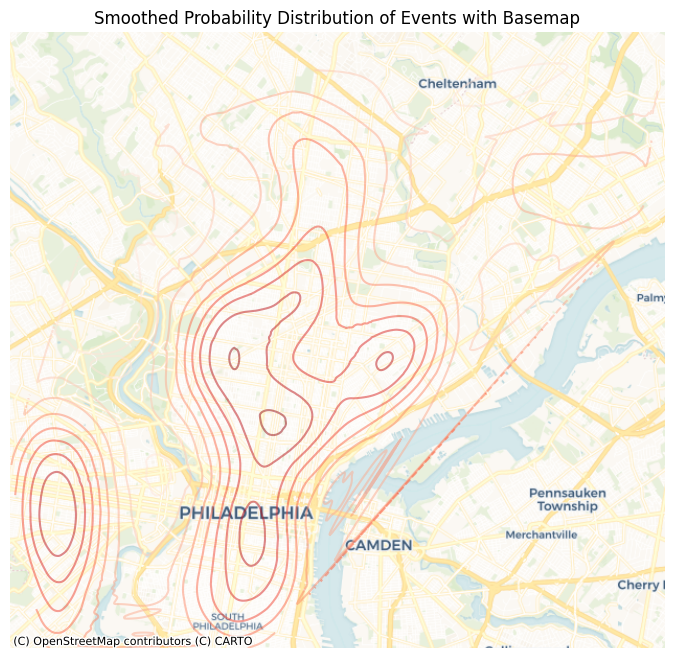

In [28]:
if __name__ == "__main__":
    file_path = 'predictions/prediction_2024-04-16.csv'
    covariance_value = 0.0001  # Change this value as needed
    main(file_path, covariance_value)

In [29]:
xf=pd.read_csv('predictions/prediction_2024-04-16mod.csv')

In [30]:
xf.sum()

Unnamed: 0                                                           361675
lat                                                              34029.0738
lon                                                              -63956.511
typ                       PROPPROPPROPPROPPROPPROPPROPPROPPROPPROPPROPPR...
normalized_probability                                                  2.0
dtype: object